In [ ]:
# !pip install tiktoken
# !pip install transformers[torch]
# !pip install scikit-learn

# **Importações**

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken # type: ignore
import nltk
from nltk.tokenize import word_tokenize
import ast

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# **Criação de arquivo tokenizado**

## **Leitura dos dados**

In [ ]:
news = pd.read_csv(r'..\AI\preprocessed\pre-processed.csv')
news = news.drop(columns=['index'])

In [15]:
news.head()

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [16]:
news['class'] = news['label'] == 'true'
news['class'] = news['class'].astype(int)

In [17]:
news.head()

,label,preprocessed_news,class
0,fake,katia abreu diz vai colocar expulsao moldura n...,0
1,fake,ray peita bolsonaro conservador fake entrevist...,0
2,fake,reinaldo azevedo desmascarado policia federal ...,0
3,fake,relatorio assustador bndes mostra dinheiro pub...,0
4,fake,radialista americano fala sobre pt vendem ilus...,0


## **Tokenização**

### com tiktoken

In [47]:
enconding = tiktoken.get_encoding('o200k_base')

In [19]:
first_news_token = enconding.encode(news['preprocessed_news'][0])
print(first_news_token)
print(enconding.decode(first_news_token))

[14408, 535, 692, 40962, 17259, 12156, 47242, 106492, 3458, 24575, 2705, 46625, 167645, 6385, 11323, 9015, 535, 692, 40962, 17699, 106492, 3458, 10074, 3687, 21905, 1375, 3458, 11531, 3419, 26044, 190748, 19475, 21530, 3857, 939, 36427, 21527, 11257, 277, 24575, 2705, 131023, 1194, 106492, 3458, 9693, 831, 365, 16505, 81815, 540, 37886, 31954, 4664, 7010, 10495, 40182, 14665, 106492, 12641, 46625, 2096, 347, 30321, 2096, 347, 30321, 58488, 13053, 2453, 17699, 9015, 535, 692, 40962, 118426, 106492, 3458, 13967, 36992, 19208, 10495, 40182, 73374, 58282, 83302, 9015, 535, 61815, 39531, 105384, 9015, 535, 46625, 11821, 18961, 30967, 3165, 84082, 17795, 29297, 24766, 18961, 27391, 1093, 9015, 535, 49726, 285, 5538, 344, 7072, 258, 926, 138568, 15908, 10074, 3687, 322, 116530, 277, 47249, 55968, 9015, 535, 35342, 58282, 1975, 17055, 172879, 6925, 12538, 365, 11564, 28397, 12102, 18961, 46625, 179719, 283, 9015, 535, 692, 40962, 1974, 17331, 4581, 16693, 2506, 292, 1578, 117299, 13812, 809]
k

In [20]:
news['tokens'] = news['preprocessed_news'].apply(lambda x: enconding.encode(x))

In [21]:
news['num_tokens'] = news['tokens'].apply(len)

In [22]:
news.head()

,label,preprocessed_news,class,tokens,num_tokens
0,fake,katia abreu diz vai colocar expulsao moldura n...,0,"[14408, 535, 692, 40962, 17259, 12156, 47242, ...",154
1,fake,ray peita bolsonaro conservador fake entrevist...,0,"[25430, 1045, 2580, 7271, 81783, 13953, 3723, ...",210
2,fake,reinaldo azevedo desmascarado policia federal ...,0,"[264, 1028, 2408, 130965, 191981, 731, 4227, 6...",271
3,fake,relatorio assustador bndes mostra dinheiro pub...,0,"[6004, 31554, 180151, 3723, 287, 301, 268, 453...",509
4,fake,radialista americano fala sobre pt vendem ilus...,0,"[19027, 563, 3857, 94277, 60486, 4844, 18961, ...",97


In [25]:
news.to_csv('tokenized.csv', sep='\t', index=False)

# **Processo com o arquivo tokenizado**

In [31]:
news = pd.read_csv(r'..\AI\preprocessed\tokenized.csv', sep='\t')
news['tokens'] = news['tokens'].apply(ast.literal_eval)
news.head()

,label,preprocessed_news,class,tokens,num_tokens
0,fake,katia abreu diz vai colocar expulsao moldura n...,0,"[14408, 535, 692, 40962, 17259, 12156, 47242, ...",154
1,fake,ray peita bolsonaro conservador fake entrevist...,0,"[25430, 1045, 2580, 7271, 81783, 13953, 3723, ...",210
2,fake,reinaldo azevedo desmascarado policia federal ...,0,"[264, 1028, 2408, 130965, 191981, 731, 4227, 6...",271
3,fake,relatorio assustador bndes mostra dinheiro pub...,0,"[6004, 31554, 180151, 3723, 287, 301, 268, 453...",509
4,fake,radialista americano fala sobre pt vendem ilus...,0,"[19027, 563, 3857, 94277, 60486, 4844, 18961, ...",97


## **Vetorização**

In [35]:
def slice_tokens(token, max_len):
    if len(token) > max_len:
        token = token[:max_len]
    elif len(token) < max_len:
        token = token + [0]*(max_len-len(token))
    
    return token

In [36]:
news['128_tokens'] = news['tokens'].apply(lambda token: slice_tokens(token, 128))
news['256_tokens'] = news['tokens'].apply(lambda token: slice_tokens(token, 256))
news['512_tokens'] = news['tokens'].apply(lambda token: slice_tokens(token, 512))
news['1024_tokens'] = news['tokens'].apply(lambda token: slice_tokens(token, 1024))

In [40]:
news.head()

,label,preprocessed_news,class,tokens,num_tokens,128_tokens,256_tokens,512_tokens,1024_tokens
0,fake,katia abreu diz vai colocar expulsao moldura n...,0,"[14408, 535, 692, 40962, 17259, 12156, 47242, ...",154,"[14408, 535, 692, 40962, 17259, 12156, 47242, ...","[14408, 535, 692, 40962, 17259, 12156, 47242, ...","[14408, 535, 692, 40962, 17259, 12156, 47242, ...","[14408, 535, 692, 40962, 17259, 12156, 47242, ..."
1,fake,ray peita bolsonaro conservador fake entrevist...,0,"[25430, 1045, 2580, 7271, 81783, 13953, 3723, ...",210,"[25430, 1045, 2580, 7271, 81783, 13953, 3723, ...","[25430, 1045, 2580, 7271, 81783, 13953, 3723, ...","[25430, 1045, 2580, 7271, 81783, 13953, 3723, ...","[25430, 1045, 2580, 7271, 81783, 13953, 3723, ..."
2,fake,reinaldo azevedo desmascarado policia federal ...,0,"[264, 1028, 2408, 130965, 191981, 731, 4227, 6...",271,"[264, 1028, 2408, 130965, 191981, 731, 4227, 6...","[264, 1028, 2408, 130965, 191981, 731, 4227, 6...","[264, 1028, 2408, 130965, 191981, 731, 4227, 6...","[264, 1028, 2408, 130965, 191981, 731, 4227, 6..."
3,fake,relatorio assustador bndes mostra dinheiro pub...,0,"[6004, 31554, 180151, 3723, 287, 301, 268, 453...",509,"[6004, 31554, 180151, 3723, 287, 301, 268, 453...","[6004, 31554, 180151, 3723, 287, 301, 268, 453...","[6004, 31554, 180151, 3723, 287, 301, 268, 453...","[6004, 31554, 180151, 3723, 287, 301, 268, 453..."
4,fake,radialista americano fala sobre pt vendem ilus...,0,"[19027, 563, 3857, 94277, 60486, 4844, 18961, ...",97,"[19027, 563, 3857, 94277, 60486, 4844, 18961, ...","[19027, 563, 3857, 94277, 60486, 4844, 18961, ...","[19027, 563, 3857, 94277, 60486, 4844, 18961, ...","[19027, 563, 3857, 94277, 60486, 4844, 18961, ..."


In [70]:
tokens = ['128_tokens', '256_tokens', '512_tokens', '1024_tokens']
y = news['class']

## **Treinamento**

### Logistic Regression

In [78]:
max_iter = 2000
for token_collumn in tokens:
    print(f'treinamento {token_collumn}')
    x = news[token_collumn].to_list()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    lr_model = LogisticRegression(max_iter=max_iter)
    lr_model.fit(x_train,y_train)
    y_pred = lr_model.predict(x_test)
    print(lr_model.score(x_test,y_test))
    print(classification_report(y_test,y_pred))


treinamento 128_tokens
0.6486111111111111
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       718
           1       0.63      0.71      0.67       722

    accuracy                           0.65      1440
   macro avg       0.65      0.65      0.65      1440
weighted avg       0.65      0.65      0.65      1440

treinamento 256_tokens
0.8972222222222223
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       718
           1       0.87      0.94      0.90       722

    accuracy                           0.90      1440
   macro avg       0.90      0.90      0.90      1440
weighted avg       0.90      0.90      0.90      1440

treinamento 512_tokens
0.8979166666666667
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       718
           1       0.91      0.89      0.90       722

    accuracy                           0.90      1440
  

c:\Users\joelr\anaconda3\envs\IAra\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


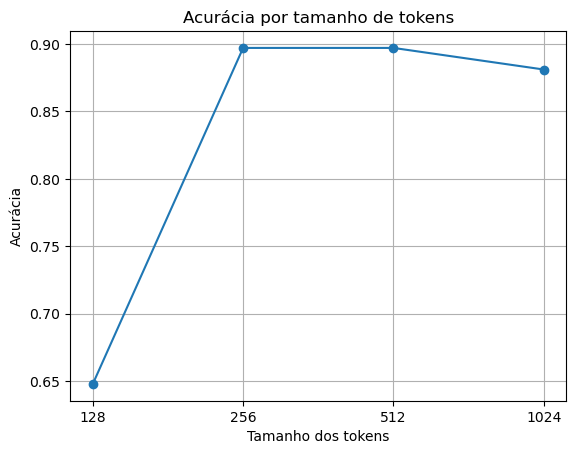

In [79]:
tokens_numbers = ['128', '256', '512', '1024']
accuracies = [0.648, 0.897, 0.897, 0.881]

plt.plot(tokens_numbers, accuracies, marker='o')
plt.title('Acurácia por tamanho de tokens')
plt.xlabel('Tamanho dos tokens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

### Decision Tree classifier

In [ ]:
max_iter = 2000
for token_collumn in tokens:
    print(f'treinamento {token_collumn}')
    x = news[token_collumn].to_list()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    dt_model = DecisionTreeClassifier()
    dt_model.fit(x_train,y_train)
    y_pred = dt_model.predict(x_test)
    print(dt_model.score(x_test,y_test))
    print(classification_report(y_test,y_pred))

treinamento 128_tokens
0.6145833333333334
              precision    recall  f1-score   support

           0       0.61      0.62      0.62       718
           1       0.62      0.61      0.61       722

    accuracy                           0.61      1440
   macro avg       0.61      0.61      0.61      1440
weighted avg       0.61      0.61      0.61      1440

treinamento 256_tokens
0.8388888888888889
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       718
           1       0.84      0.84      0.84       722

    accuracy                           0.84      1440
   macro avg       0.84      0.84      0.84      1440
weighted avg       0.84      0.84      0.84      1440

treinamento 512_tokens
0.8784722222222222
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       718
           1       0.87      0.89      0.88       722

    accuracy                           0.88      1440
  

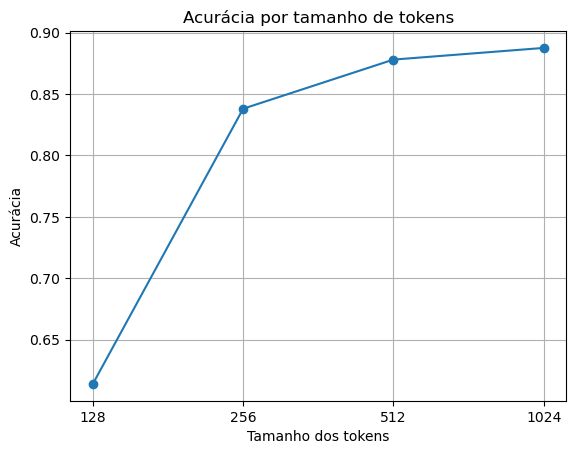

In [77]:
tokens_numbers = ['128', '256', '512', '1024']
accuracies = [0.614, 0.838, 0.878, 0.8875]

plt.plot(tokens_numbers, accuracies, marker='o')
plt.title('Acurácia por tamanho de tokens')
plt.xlabel('Tamanho dos tokens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

### Gradient Boost classifier

In [82]:
max_iter = 2000
for token_collumn in tokens:
    print(f'treinamento {token_collumn}')
    x = news[token_collumn].to_list()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    gb_model = GradientBoostingClassifier()
    gb_model.fit(x_train,y_train)
    y_pred = gb_model.predict(x_test)
    print(gb_model.score(x_test,y_test))
    print(classification_report(y_test,y_pred))

treinamento 128_tokens
0.6854166666666667
              precision    recall  f1-score   support

           0       0.86      0.44      0.58       718
           1       0.63      0.93      0.75       722

    accuracy                           0.69      1440
   macro avg       0.74      0.68      0.67      1440
weighted avg       0.74      0.69      0.67      1440

treinamento 256_tokens
0.9222222222222223
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       718
           1       0.89      0.97      0.93       722

    accuracy                           0.92      1440
   macro avg       0.93      0.92      0.92      1440
weighted avg       0.93      0.92      0.92      1440

treinamento 512_tokens
0.93125
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       718
           1       0.93      0.93      0.93       722

    accuracy                           0.93      1440
   macro avg 

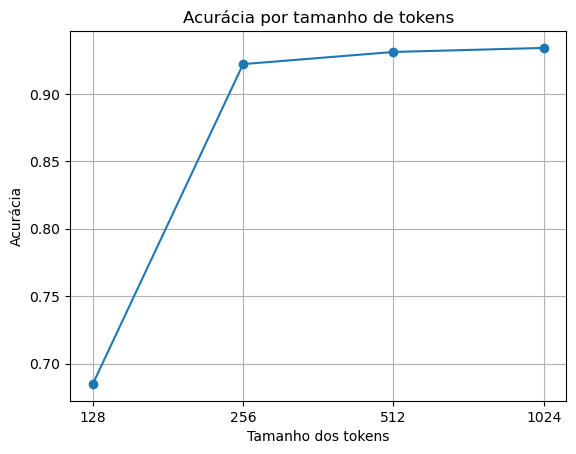

In [83]:
tokens_numbers = ['128', '256', '512', '1024']
accuracies = [0.685, 0.922, 0.931, 0.934]

plt.plot(tokens_numbers, accuracies, marker='o')
plt.title('Acurácia por tamanho de tokens')
plt.xlabel('Tamanho dos tokens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

### Random Forest classifier

In [85]:
max_iter = 2000
for token_collumn in tokens:
    print(f'treinamento {token_collumn}')
    x = news[token_collumn].to_list()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    rf_model = RandomForestClassifier()
    rf_model.fit(x_train,y_train)
    y_pred = rf_model.predict(x_test)
    print(rf_model.score(x_test,y_test))
    print(classification_report(y_test,y_pred))

treinamento 128_tokens
0.6958333333333333
              precision    recall  f1-score   support

           0       0.94      0.42      0.58       718
           1       0.63      0.97      0.76       722

    accuracy                           0.70      1440
   macro avg       0.78      0.70      0.67      1440
weighted avg       0.78      0.70      0.67      1440

treinamento 256_tokens
0.9201388888888888
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       718
           1       0.88      0.97      0.92       722

    accuracy                           0.92      1440
   macro avg       0.92      0.92      0.92      1440
weighted avg       0.92      0.92      0.92      1440

treinamento 512_tokens
0.9354166666666667
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       718
           1       0.94      0.93      0.94       722

    accuracy                           0.94      1440
  

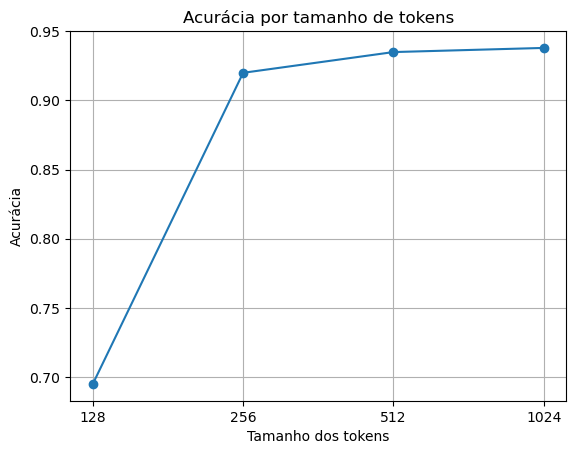

In [86]:
tokens_numbers = ['128', '256', '512', '1024']
accuracies = [0.695, 0.920, 0.935, 0.938]

plt.plot(tokens_numbers, accuracies, marker='o')
plt.title('Acurácia por tamanho de tokens')
plt.xlabel('Tamanho dos tokens')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()